# JAX Implementation of Gaussian VAE

In this notebook, we implemented a VAE where both the encoder and decoder model gaussian distributions. The model is trained on CelebA 64x64.

This implementation is in JAX.

For Tensorflow and Pytorch implementations, check the other notebooks.

In [1]:
import tensorflow as tf
import os

# Prevent tensorflow from using GPUs
tf.config.set_visible_devices([], device_type='GPU')

2025-01-02 14:39:30.003926: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735825170.020499  623226 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735825170.025552  623226 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-02 14:39:30.042774: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from clu import parameter_overview
import distrax
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple
import orbax.checkpoint
from flax.training import orbax_utils
import optax

from flax import jax_utils
from flax.training.train_state import TrainState
import flax
from flax import linen as nn  # Linen API

import warnings

## Run Hyperparams

Define the training params.

`WARMUP_STEPS` defines the number of training updates over which we do a linear learning rate warmup. We found that such a learning rate warmup is very useful for model stability in the early stages of training.

`ENCODER_CONV_UNITS` and `DECODER_CONV_UNITS` are lists of lists. The outer list is a list of layers. Each layer is defined as a list of `[channels, kernel_size, stride, activation, name]`.

`ENCODER_DENSE_UNITS` and `DECODER_DENSE_UNITS` are lists of lists. The outer list is a list of layers. Each layer is defined as a list of `[channels, activation, name]`.

In [3]:
# RNG params
GLOBAL_KEY = random.key(2409)

# Data params
INPUT_SHAPE = (64,64,3)

# Training params
BATCH_SIZE = 64
TOTAL_TRAINING_STEPS = 200000
EVAL_EVERY_N_STEPS = 2000
VALIDATION_STEPS = 50

# Optimizer params
INITIAL_LEARNING_RATE = 1e-3
DECAY_STEPS = 50000
DECAY_RATE = 0.5
WARMUP_STEPS = 1000

# Model params
ENCODER_CONV_UNITS = [[128,(4,4),(1,1), nn.activation.relu],   
                      [128,(4,4),(2,2), nn.activation.relu],   
                      [256,(4,4),(2,2), nn.activation.relu], 
                      [256,(4,4),(2,2), nn.activation.relu], 
                      [256,(4,4),(1,1), nn.activation.relu]]  

ENCODER_DENSE_UNITS = [[256, nn.activation.relu], 
                       [256 * 2, None]]

DECODER_DENSE_UNITS = [[256, nn.activation.relu], 
                       [256 * 8 * 8, nn.activation.relu]]

DECODER_CONV_UNITS = [[256,(4,4),(1,1), nn.activation.relu],
                      [256,(4,4),(2,2), nn.activation.relu],
                      [256,(4,4),(2,2), nn.activation.relu],
                      [128,(4,4),(2,2), nn.activation.relu],
                      [3*2,(4,4),(1,1), None]]

## Data processing

In [4]:
from ilms.data import CelebAIterator, create_pipeline
from nvidia.dali.plugin.jax import DALIGenericIterator
train_src = CelebAIterator(BATCH_SIZE, 'train')
val_src = CelebAIterator(BATCH_SIZE, 'val')

train_pipeline = create_pipeline(BATCH_SIZE, train_src)

val_pipeline = create_pipeline(BATCH_SIZE, val_src)

train_pipeline.build()
val_pipeline.build()



train_dataset = DALIGenericIterator([train_pipeline], ['image'])
val_dataset = DALIGenericIterator([val_pipeline], ['image'])

Found 162770 images in train set
Found 19867 images in val set


## Definining loss

For the Loss, we use the `Negative ELBO = -likelihood + KL_div`.

- `likelihood = decoder_dist.log_pdf(targets)`
- `KL_div = KL(posterior_dist || prior_dist)`
- The `posterior_dist` is the encoder distribution.
- For simplicity, we set the prior distribution to be a simple standard Gaussian `N(0, 1)`.

To help the model avoid a posterior collapse, we warmup the `KL_div` by linearly scaling it up over 10000 steps.

In [5]:
# Define the shape of z based on hparams
def z_shape():
    return [BATCH_SIZE, ENCODER_DENSE_UNITS[-1][0] // 2]

print(z_shape())

class NelboLoss():
    def __init__(self):
        self.prior = distrax.Normal(jnp.zeros(z_shape()),jnp.ones(z_shape()))
        
    def __call__(self, dec_mean, dec_logstd,enc_mean,enc_logstd, targets,step):
        likelihood = distrax.Normal(dec_mean, jnp.exp(jnp.maximum(dec_logstd, -10.))).log_prob(targets) 
        kl = distrax.Normal(enc_mean,jnp.exp(jnp.maximum(enc_logstd,-10.))).kl_divergence(self.prior) 
        denominator = jnp.prod(jnp.array(likelihood.shape)).astype(jnp.float32)
        reconstuction_loss =-jnp.sum(likelihood)/denominator
        kl_loss = (jnp.sum(kl)/denominator)*jnp.minimum(step.astype(jnp.float32)*1e-4,1.)
        neg_elbo = reconstuction_loss+kl_loss    # ()
        return neg_elbo, reconstuction_loss, kl_loss

[32, 256]


## Defining model

In [6]:
# Define the unflatten shape used in the decoder based on hparams
def unflatten_shape():
    h,w = INPUT_SHAPE[:2]
    for stride in ENCODER_CONV_UNITS:
        h = h//stride[2][0]
        w = w//stride[2][1]   
    
    assert DECODER_DENSE_UNITS[-1][0] % (h*w) == 0
    unflatten_C = DECODER_DENSE_UNITS[-1][0] // (h*w)
    x=(BATCH_SIZE, h, w, unflatten_C)
    return x

print(unflatten_shape())

(32, 8, 8, 256)


In [7]:
class EncoderConvs(nn.Module):
    """
    Encoder Block.

    The Block is made of convolutions that downsample the image
    resolution until a certain point, after which we flatten the image
    and use a stack of Dense layers to get the posterior distribution q(z|x).
    """
    def setup(self):
        convs_list = []        
        for filters, kernel_size, stride, activation in ENCODER_CONV_UNITS:
            convs_list.append(nn.Conv(filters, kernel_size, stride))
            if activation is not None:
                convs_list.append(activation)
        self.convs_list = convs_list

        dense_list = []
        for filters, activation in ENCODER_DENSE_UNITS:
            dense_list.append(nn.Dense(filters))
            if activation is not None:
                dense_list.append(activation)

        self.dense_list = dense_list
        
                
    def __call__(self,x):
        for conv in self.convs_list:
            x = conv(x)

        # (B, h, w, C) -> (B, h*w*C)
        x = jnp.reshape(x, shape=(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3]))
        
        for dense in self.dense_list:
            x = dense(x)
        return x  

class ResizeAndConv(nn.Module):
    """
    Resize-Conv Block.

    A simple Nearest-Neighbord upsampling + Conv block, used to upsample images instead of Deconv layers.
    This block is useful to avoid checkerboard artifacts: https://distill.pub/2016/deconv-checkerboard/
    """
    filters: int
    kernel_size: Tuple[int]
    stride: Tuple[int]

    def setup(self):
        self.conv = nn.Conv(self.filters, self.kernel_size, (1,1))
        
    def __call__(self,x):
        if self.stride != (1,1):
            x = jax.image.resize(x, (x.shape[0], x.shape[1]*self.stride[0],x.shape[2]*self.stride[1],x.shape[3]), method = 'nearest')
        x = self.conv(x)
        return x
    
class DecoderConvs(nn.Module):
    """
    Decoder Block.

    The Decoder block starts off with Dense layers to process the sample z,
    followed by an unflatten (reshape) operation into an activation of shape (B, h, w, C).
    The activation is then upsampled back to the original image size using a stack
    of resize-conv blocks.
    """
    def setup(self):
        convs_list=[]        
        for filters, kernel_size, stride, activation in DECODER_CONV_UNITS:            
            convs_list.append(ResizeAndConv(filters, kernel_size, stride))
            if activation is not None:
                convs_list.append(activation)
        self.convs_list = convs_list 

        dense_list = []
        for filters, activation in DECODER_DENSE_UNITS:
            dense_list.append(nn.Dense(filters))
            if activation is not None:
                dense_list.append(activation)

        self.dense_list = dense_list
              
    def __call__(self,x):
        for dense in self.dense_list:
            x = dense(x)

        # (B, C) -> (B, h, w, new_C)
        x = jnp.reshape(x,shape=unflatten_shape())
        
        for conv in self.convs_list:
            x = conv(x)
        
        return x   

class VAEModel(nn.Module):
    """
    VAE model.

    A simple Encoder-Decoder architecture where both Encoder and Decoder model multivariate
    gaussian distributions.
    """
    def setup(self):
        self.encoder_convs = EncoderConvs()
        self.decoder_convs = DecoderConvs()

    def __call__(self, key, inputs):
        enc_mean, enc_logstd = self.encode(inputs)
        epsilon = random.normal(key, enc_mean.shape)
        z = epsilon * jnp.exp(enc_logstd) + enc_mean
        dec_mean, dec_logstd = self.decode(z)
        return enc_mean, enc_logstd, dec_mean, dec_logstd

    def encode(self, inputs):
        enc_x = self.encoder_convs(inputs)
        enc_mean, enc_logstd = jnp.split(enc_x, 2, axis=-1)
        return enc_mean, enc_logstd

    def decode(self, z):
        dec_x = self.decoder_convs(z)
        dec_mean, dec_logstd = jnp.split(dec_x, 2, axis=-1)
        return dec_mean, dec_logstd
    
    def generate(self, key, z_temp=1., x_temp=1.):
        """
        Randomly sample z from the prior distribution N(0, 1) and generate the image x from z.

        z_temp: float, defines the temperature multiplier of the encoder stddev. 
            Smaller z_temp makes the generated samples less diverse and more generic
        x_temp: float, defines the temperature multiplier of the decoder stddev.
            Smaller x_temp makes the generated samples smoother, and loses small degree of information.
        """
        # Generate random samples from the prior distribution N(0, 1)
        key1, key2 = random.split(key)

        z = random.normal(key1, z_shape())
        z = z * z_temp  # "Reparametrization" to N(0, 1 * z_temp)
        
        dec_mean, dec_logstd = self.decode(z)
        return distrax.Normal(dec_mean, jnp.exp(dec_logstd) * x_temp).sample(seed=key2)

In [8]:
model = VAEModel()

In [9]:
# Initialize the mode weights using a dummy input
training_key, generation_key, x_key, init_key = random.split(GLOBAL_KEY, 4)
x = random.normal(x_key, (BATCH_SIZE, *INPUT_SHAPE))
params = model.init(init_key, init_key, x)

print(parameter_overview.get_parameter_overview(params))

2025-01-02 14:39:43.787011: W external/xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.10GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


+-----------------------------------------------+------------------+---------+-----------+-----------+---------+
| Name                                          | Shape            | Dtype   | Size      | Mean      | Std     |
+-----------------------------------------------+------------------+---------+-----------+-----------+---------+
| params/decoder_convs/convs_list_0/conv/bias   | (256,)           | float32 | 256       | 0.0       | 0.0     |
| params/decoder_convs/convs_list_0/conv/kernel | (4, 4, 256, 256) | float32 | 1,048,576 | -7.87e-06 | 0.0156  |
| params/decoder_convs/convs_list_2/conv/bias   | (256,)           | float32 | 256       | 0.0       | 0.0     |
| params/decoder_convs/convs_list_2/conv/kernel | (4, 4, 256, 256) | float32 | 1,048,576 | -1.22e-06 | 0.0156  |
| params/decoder_convs/convs_list_4/conv/bias   | (256,)           | float32 | 256       | 0.0       | 0.0     |
| params/decoder_convs/convs_list_4/conv/kernel | (4, 4, 256, 256) | float32 | 1,048,576 | 3.26e

## utility functions for training

Saving and Loading checkpoints

In [10]:
def create_checkpoint_manager(checkpoint_path, max_allowed_checkpoints=2):
    orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

    options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=max_allowed_checkpoints, create=True)
    checkpoint_manager = orbax.checkpoint.CheckpointManager(
        os.path.abspath(checkpoint_path), orbax_checkpointer, options)
    return checkpoint_manager


def save_checkpoint(checkpoint_manager, step, params, opt_state):
    ckpt = {'model_params': params, 'optimizer_state': opt_state, 'step': step}
    save_args = orbax_utils.save_args_from_target(ckpt)
    
    checkpoint_manager.save(step, ckpt, save_kwargs={'save_args': save_args})


def load_checkpoint_if_exists(checkpoint_manager, params, opt_state):
    if checkpoint_manager.latest_step() is not None:
        print(f"Loading checkpoint state for step {checkpoint_manager.latest_step()} from {checkpoint_manager._directory}")
        step = checkpoint_manager.latest_step()
        ckpt = checkpoint_manager.restore(step)
        return ckpt['step'], ckpt['model_params'], ckpt['optimizer_state']

    print(f"Couldn't find state checkpoints to load in {checkpoint_manager._directory}!!")
    return 0, params, opt_state

Metrics book keeping and plotting utilities

In [11]:
def plot_samples(tdec_mean, tdec_logstd, ttargets, vdec_mean, vdec_logstd, vtargets, key):
    keys = random.split(key, num=4)
    _, axes = plt.subplots(1,8,figsize=(8,4))
    axes[0].imshow(ttargets[0])
    axes[1].imshow(distrax.Normal(tdec_mean[0],tf.math.exp(tdec_logstd[0])).sample(seed=keys[0]))
    axes[2].imshow(ttargets[1])
    axes[3].imshow(distrax.Normal(tdec_mean[1],tf.math.exp(tdec_logstd[1])).sample(seed=keys[1]))
    axes[4].imshow(vtargets[0])
    axes[5].imshow(distrax.Normal(vdec_mean[0],tf.math.exp(vdec_logstd[0])).sample(seed=keys[2]))
    axes[6].imshow(vtargets[1])
    axes[7].imshow(distrax.Normal(vdec_mean[1],tf.math.exp(vdec_logstd[1])).sample(seed=keys[3]))
    plt.tight_layout(pad=-2.)
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show() 

# Updates dictionary that stores changes in loss values
def get_results(results, losses):
    for i,key in enumerate(results.keys()):
        results[key].append(losses[i])

Learning rate schedule utility

Training loop utilities

In [24]:
def forward(params, inputs, targets, step, key):
    """
    Forward function of the neural network (inputs -> model -> outputs -> loss).
    Created to call jax.grad on this function and do automatic differentiation for backprop.
    """
    enc_mean, enc_logstd, dec_mean, dec_logstd = model.apply({'params': params}, key, inputs)
    loss_value, rec, kl = loss(dec_mean, dec_logstd, enc_mean, enc_logstd, targets, step)
    return loss_value, (rec, kl)

@jit
def train_step(inputs, targets, step, params, opt_state, key):
    """
    Train step. XLA compiled
    """
    (nelbo,(rec, kl)), grads = jax.value_and_grad(forward, has_aux=True)(params, inputs, targets, step, key)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return nelbo, rec, kl, params, opt_state

@jit
def val_step(inputs, targets, step, params, key):
    """
    Val step. XLA compiled
    """
    enc_mean, enc_logstd, dec_mean, dec_logstd = model.apply({'params': params}, key, inputs)
    loss_value, rec, kl = loss(dec_mean, dec_logstd, enc_mean, enc_logstd, targets, step)
    return loss_value, rec, kl, dec_mean, dec_logstd

def validate(dataset, step, params, key):
    """
    Validation loop. 
    """
    avg_loss = 0.
    avg_rec = 0.
    avg_kl = 0.
    for v_step, (BATCH_SIZE) in zip(range(VALIDATION_STEPS), dataset):
        key, model_key = random.split(key) 
        inputs, targets = BATCH_SIZE['image'], BATCH_SIZE['image']
        loss_value, rec, kl, dec_mean, dec_logstd = val_step(inputs, targets, step, params, model_key)
        avg_loss += loss_value
        avg_rec += rec
        avg_kl += kl       
        
    avg_loss /= (v_step + 1)
    avg_rec /= (v_step + 1)
    avg_kl /= (v_step + 1) 
    
    return avg_loss, avg_rec, avg_kl, dec_mean[:2], dec_logstd[:2], targets[:2]
    

def validate_and_plot(train_dataset, val_dataset, step, params, key):
    """
    Validation function for both train and val data + metrics and artifacts logging.
    """
    tkey, vkey, plot_key = random.split(key, num=3)
    tavg_loss, tavg_rec, tavg_kl, tdec_mean, tdec_logstd, ttargets = validate(train_dataset, step, params, tkey)
    vavg_loss, vavg_rec, vavg_kl, vdec_mean, vdec_logstd, vtargets = validate(val_dataset, step, params, vkey)
    
    print(f"\nstep {step}/{TOTAL_TRAINING_STEPS}  train_loss:  nelbo:{tavg_loss:.4f}  rec:{tavg_rec:.4f}  kl:{tavg_kl:.4f}      "
          f"val_loss:  nelbo:{vavg_loss:.4f}  rec:{vavg_rec:.4f}  kl:{vavg_kl:.4f}")
    plot_samples(tdec_mean, tdec_logstd, ttargets, vdec_mean, vdec_logstd, vtargets, plot_key)

    return tavg_loss, tavg_rec, tavg_kl, vavg_loss, vavg_rec, vavg_kl

def train(train_dataset, val_dataset, results, params, opt_state, key):
    """
    Training loop
    """
    # Restore model if resuming training
    initial_step, params, opt_state = load_checkpoint_if_exists(checkpoint_manager, params, opt_state)

    pbar = tf.keras.utils.Progbar(EVAL_EVERY_N_STEPS, stateful_metrics=['nelbo','rec','kl'])

    for step, batch in zip(range(initial_step, TOTAL_TRAINING_STEPS+1),train_dataset):
        key, model_key = random.split(key) 
        inputs, targets = batch['image'], batch['image']
        nelbo, rec, kl, params, opt_state = train_step(inputs, targets, step, params, opt_state, model_key) 
        pbar.update(step % EVAL_EVERY_N_STEPS, [('nelbo', nelbo),('rec', rec),('kl', kl)])
                    
        if step % EVAL_EVERY_N_STEPS == 0:
            losses = validate_and_plot(train_dataset, val_dataset, step, params, key)
            # update the results dict with latest metrics
            get_results(results, losses)

            # Save new model checkpoint
            save_checkpoint(checkpoint_manager, step, params, opt_state)
            print(f'SAVED CHECKPOINT FOR STEP {step}..')

## Model training

In [25]:
# Define this run's model name
MODEL_NAME = 'vae_celeba64_dense256'

loss = NelboLoss()

lr_schedule = optax.warmup_exponential_decay_schedule(init_value=0, peak_value=INITIAL_LEARNING_RATE, 
                                                    warmup_steps=WARMUP_STEPS, 
                                                    transition_steps=DECAY_STEPS, 
                                                    decay_rate=DECAY_RATE)
optimizer = optax.adamax(lr_schedule)
opt_state = optimizer.init(params['params'])

checkpoint_manager = create_checkpoint_manager(checkpoint_path=f'jax_checkpoints/{MODEL_NAME}')

Couldn't find state checkpoints to load in /home/stasy/work1/dali_test/jax_checkpoints/vae_celeba64_dense256!!
   0/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - nelbo: 1.1054 - rec: 1.1054 - kl: 0.0000e+00

2025-01-02 14:42:02.178106: W external/xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.10GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.



step 0/200000  train_loss:  nelbo:1.0982  rec:1.0982  kl:0.0000      val_loss:  nelbo:1.1006  rec:1.1006  kl:0.0000


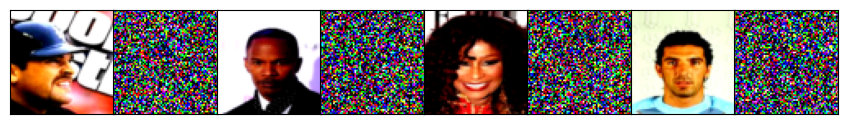

SAVED CHECKPOINT FOR STEP 0..
   0/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - nelbo: -0.7951 - rec: -0.8085 - kl: 0.0134   l: 0.013


step 2000/200000  train_loss:  nelbo:-0.7397  rec:-0.7536  kl:0.0140      val_loss:  nelbo:-0.7439  rec:-0.7578  kl:0.0140


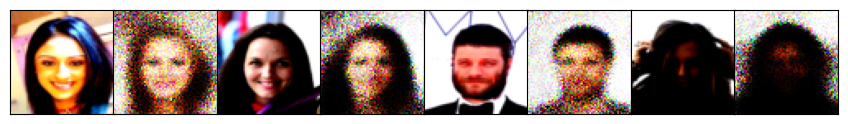

SAVED CHECKPOINT FOR STEP 2000..
   0/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - nelbo: -0.9832 - rec: -1.0141 - kl: 0.0308   l: 0.033


step 4000/200000  train_loss:  nelbo:-0.8119  rec:-0.8407  kl:0.0288      val_loss:  nelbo:-0.8066  rec:-0.8354  kl:0.0288


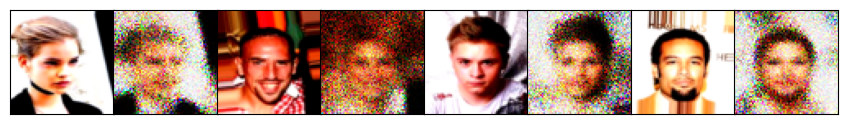

SAVED CHECKPOINT FOR STEP 4000..
   0/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - nelbo: -1.1243 - rec: -1.1641 - kl: 0.0398   l: 0.041


step 6000/200000  train_loss:  nelbo:-1.1257  rec:-1.1655  kl:0.0398      val_loss:  nelbo:-1.0995  rec:-1.1393  kl:0.0398


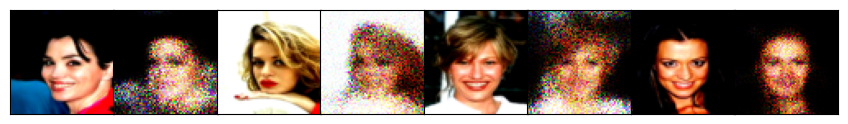

SAVED CHECKPOINT FOR STEP 6000..
   0/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - nelbo: -1.2541 - rec: -1.3182 - kl: 0.0641   l: 0.063


step 8000/200000  train_loss:  nelbo:-1.2723  rec:-1.3357  kl:0.0634      val_loss:  nelbo:-1.1981  rec:-1.2619  kl:0.0638


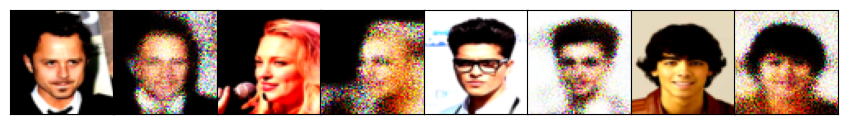

SAVED CHECKPOINT FOR STEP 8000..
   0/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - nelbo: -1.5281 - rec: -1.6061 - kl: 0.0780   l: 0.082


step 10000/200000  train_loss:  nelbo:-1.3728  rec:-1.4513  kl:0.0784      val_loss:  nelbo:-1.3975  rec:-1.4759  kl:0.0784


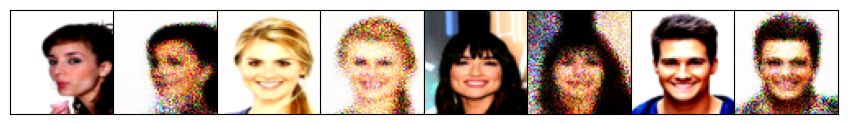

SAVED CHECKPOINT FOR STEP 10000..
1758/2000 ━━━━━━━━━━━━━━━━━━━━ 25s 105ms/step - nelbo: -1.3824 - rec: -1.4622 - kl: 0.0798

KeyboardInterrupt: 

In [ ]:
results = {'nelbo':[],'rec':[],'kl':[],'val_nelbo':[],'val_rec':[],'val_kl':[]}
start_time=time()
train(train_dataset, val_dataset, results, params['params'], opt_state, training_key)
end_time=time()
print(f'Total time for {TOTAL_TRAINING_STEPS} is {end_time-start_time:.2f}s')

plot the loss curves

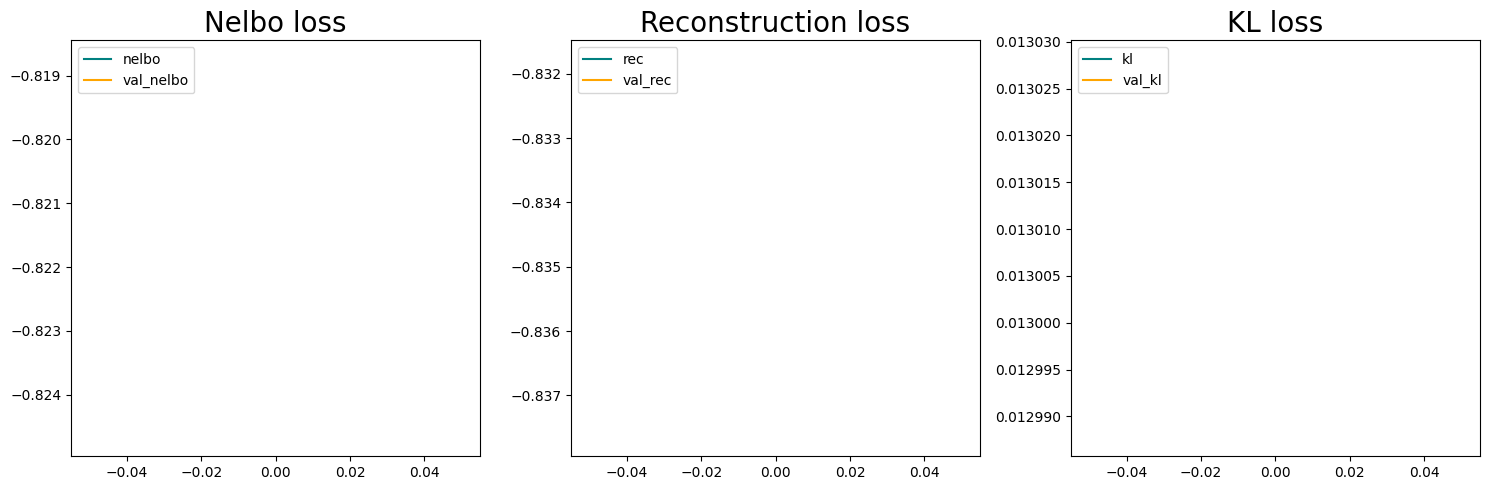

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(results['nelbo'][1:], color='teal', label='nelbo')
axes[0].plot(results['val_nelbo'][1:], color='orange', label='val_nelbo')
axes[0].set_title('Nelbo loss', fontsize=20)
axes[0].legend(loc="upper left")

axes[1].plot(results['rec'][1:], color='teal', label='rec')
axes[1].plot(results['val_rec'][1:], color='orange', label='val_rec')
axes[1].set_title('Reconstruction loss', fontsize=20)
axes[1].legend(loc="upper left")

axes[2].plot(results['kl'][1:], color='teal', label='kl')
axes[2].plot(results['val_kl'][1:], color='orange', label='val_kl')
axes[2].set_title('KL loss', fontsize=20)
axes[2].legend(loc="upper left")

plt.tight_layout()
plt.show()

## Model Generation

In this section, we generate new images from the prior distribution

In [17]:
# choose the model to generate from
MODEL_NAME = 'vae_celeba64_dense256'

# initialize the mode weights using a dummy input
training_key, generation_key, x_key, init_key = random.split(GLOBAL_KEY, 4)
x = random.normal(x_key, (BATCH_SIZE, *INPUT_SHAPE))
params = model.init(init_key, init_key, x)

loss = NelboLoss()
lr_schedule = optax.warmup_exponential_decay_schedule(init_value=0, peak_value=INITIAL_LEARNING_RATE, 
                                                    warmup_steps=WARMUP_STEPS, 
                                                    transition_steps=DECAY_STEPS, 
                                                    decay_rate=DECAY_RATE)
optimizer = optax.adamax(lr_schedule)
opt_state = optimizer.init(params['params'])

# Load model checkpoint
checkpoint_manager = create_checkpoint_manager(checkpoint_path=f'jax_checkpoints/{MODEL_NAME}')
initial_step, params, opt_state = load_checkpoint_if_exists(checkpoint_manager, params, opt_state)

Loading checkpoint state for step 2000 from /home/rayhane/JocaProjects/celeba_vae/jax_checkpoints/vae_celeba64_dense256


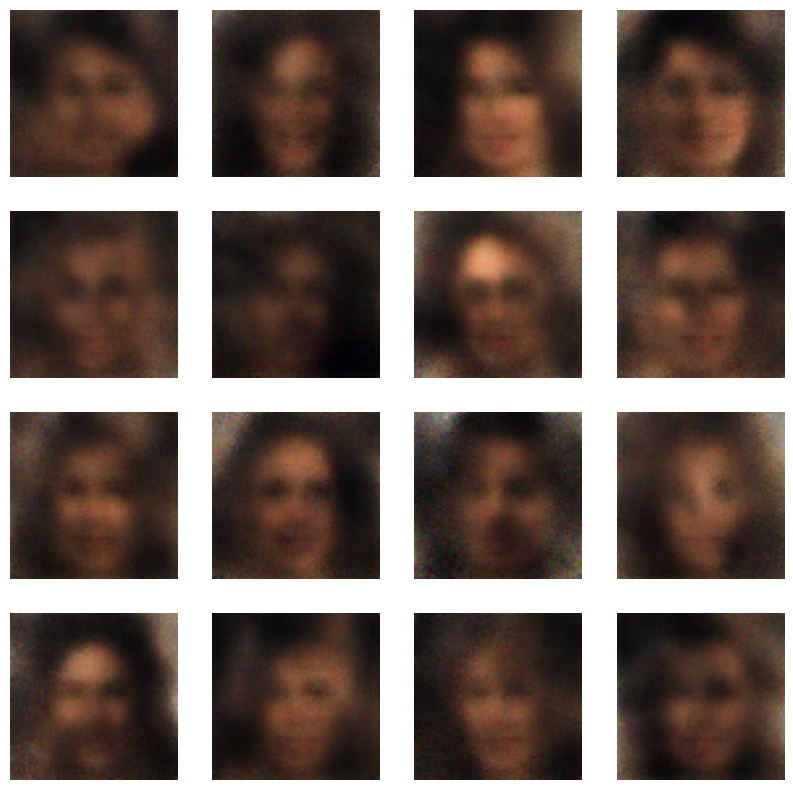

In [18]:
# Pick encoder distribution temperature (z_temp) and decoder distribution temperature (x_temp)
# Generate from the prior
generation_key, key = random.split(generation_key)
pictures = model.apply({'params': params}, key, 1., 0.3, method=model.generate)

# Plot grid of generated pictures
fig, axes32 = plt.subplots(4,4, figsize=(10,10))
for i, axes8 in enumerate(axes32):
    for j, ax in enumerate(axes8):
        index = i * axes32.shape[1] + j
        ax.imshow(pictures[index])
        ax.axis('off')
plt.show()